In [31]:
import numpy as np
import itertools
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import dask
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import pandas as pd
import netCDF4

In [32]:
def latent_space_analysis(Images, title, iden):
    mean_image = np.mean(Images, axis=0)
    var_image = np.std(Images, axis=0)
    cmap="RdBu_r"
    fig, ax = plt.subplots(1,2, figsize=(16,2))
    cs0 = ax[0].imshow(var_image, cmap=cmap)
    ax[0].set_title("Image Standard Deviation")
    cs1 = ax[1].imshow(mean_image, cmap=cmap)
    ax[1].set_title("Image Mean")
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[1].set_ylim(ax[1].get_ylim()[::-1])
    ax[1].set_xlabel("CRMs")
    ax[0].set_xlabel("CRMs")
    ax[0].set_ylabel("Pressure")
    ax[1].set_yticks([])
    y_ticks = np.arange(1300, 0, -300)
    ax[0].set_yticklabels(y_ticks)
    ax[1].set_yticklabels(y_ticks)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs0, cax=cax)
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs1, cax=cax)
    plt.suptitle(title)
    #plt.savefig("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/model_graphs/latent_space_components/"+iden+'_'+title+'.png')
 

In [33]:
Train_Images = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_W_Training.npy")
Test_Images = np.load("/fast/gmooers/Preprocessed_Data/W_Variable/Trackable_Space_Time_W_Test.npy")

Max_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Max_Scalar.npy")
Min_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Min_Scalar.npy")

Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))
Train_Images = np.interp(Train_Images, (0, 1), (Min_Scalar, Max_Scalar))

In [34]:
Test_Images = np.reshape(Test_Images, (len(Test_Images),30*128))
Train_Images = np.reshape(Train_Images, (len(Train_Images),30*128))

In [35]:
sc = StandardScaler()
z_train_std = sc.fit_transform(Train_Images)
#z_train_std = sc.fit_transform(train_log_var)
    
z_test_std = sc.transform(Test_Images)
#z_test_std = sc.transform(test_log_var)
# Instantiate PCA 
pca = PCA(n_components=2)
pca.fit(z_train_std)
z_test_tsne = pca.transform(z_test_std)

In [36]:
Test_Images = np.reshape(Test_Images, (len(Test_Images),30,128))
Train_Images = np.reshape(Train_Images, (len(Train_Images),30,128))

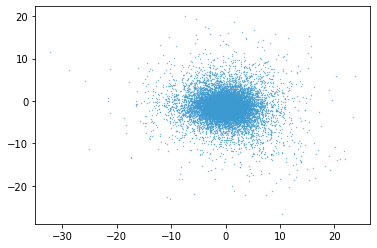

In [37]:
plt.scatter(x=z_test_tsne[:, 0], y=z_test_tsne[:, 1], c="#3D9AD1", s=0.1)
plt.show()

In [66]:
horz_line = np.squeeze(np.argwhere(np.logical_and(z_test_tsne[:,1] > -1.03, z_test_tsne[:,1] < -0.970)))
vert_line = np.squeeze(np.argwhere(np.logical_and(z_test_tsne[:,0] > -0.008, z_test_tsne[:,0] < 0.008)))
#horz_line = np.squeeze(np.argwhere(np.logical_and(z_test_tsne[:,1] > -8.005, z_test_tsne[:,1] < -7.995)))
#vert_line = np.squeeze(np.argwhere(np.logical_and(z_test_tsne[:,0] > -12.025, z_test_tsne[:,0] < -11.975)))

In [67]:
horz_line_images = Test_Images[horz_line,:,:]
horz_line_latent = z_test_tsne[horz_line,:]

vert_line_images = Test_Images[vert_line,:,:]
vert_line_latent = z_test_tsne[vert_line,:]

horz_line_images_sorted = np.empty(horz_line_images.shape)
horz_line_latent_sorted = np.empty(horz_line_latent.shape)
vert_line_images_sorted = np.empty(vert_line_images.shape)
vert_line_latent_sorted = np.empty(vert_line_latent.shape)

In [68]:
count = 0
for i in range(len(horz_line_images_sorted)):
    ind = np.nanargmin(horz_line_latent[:,0])
    horz_line_images_sorted[count,:] = horz_line_images[ind,:]
    horz_line_latent_sorted[count,:] = horz_line_latent[ind,:]
    horz_line_latent[ind,:] = np.array([1000.0,1000.0])
    #horz_line_images[ind,:] = np.array([1000.0,1000.0])
    count = count+1
    
count = 0
for i in range(len(vert_line_images_sorted)):
    ind = np.nanargmin(vert_line_latent[:,1])
    vert_line_images_sorted[count,:] = vert_line_images[ind,:]
    vert_line_latent_sorted[count,:] = vert_line_latent[ind,:]
    vert_line_latent[ind,:] = np.array([10000.0,10000.0])
    #vert_line_image[ind,:] = np.array([1000.0,1000.0])
    count = count+1
    

In [69]:
print(np.where(z_test_tsne == horz_line_latent_sorted[0]))
print(np.where(z_test_tsne == horz_line_latent_sorted[-1]))
print(np.where(z_test_tsne == vert_line_latent_sorted[0]))
print(np.where(z_test_tsne == vert_line_latent_sorted[-1]))

(array([3387, 3387]), array([0, 1]))
(array([42512, 42512]), array([0, 1]))
(array([50375, 50375]), array([0, 1]))
(array([1022, 1022]), array([0, 1]))


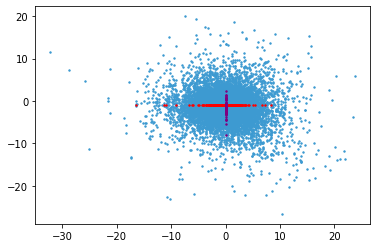

In [70]:
plt.scatter(x=z_test_tsne[:, 0], y=z_test_tsne[:, 1], c="#3D9AD1", s=2.0)
plt.scatter(x=horz_line_latent_sorted[:, 0], y=horz_line_latent_sorted[:, 1], c="Red", s=2.0)
plt.scatter(x=vert_line_latent_sorted[:, 0], y=vert_line_latent_sorted[:, 1], c="Purple", s=2.0)
plt.show()

In [71]:
print(horz_line_latent_sorted.shape)
print(vert_line_latent_sorted.shape)

(721, 2)
(614, 2)


In [72]:
path = "/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyai.values
hb = extra_variables.hybi.values
PS = 1e5
Pressures_real = PS*ha+PS*hb

fz = 15
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
levs = np.array(others.variables['lev'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [73]:
horz_line_latent_sorted = np.flip(horz_line_latent_sorted, axis=0)
vert_line_latent_sorted = np.flip(vert_line_latent_sorted, axis=0)
horz_line_images_sorted = np.flip(horz_line_images_sorted, axis=0)
vert_line_images_sorted = np.flip(vert_line_images_sorted, axis=0)

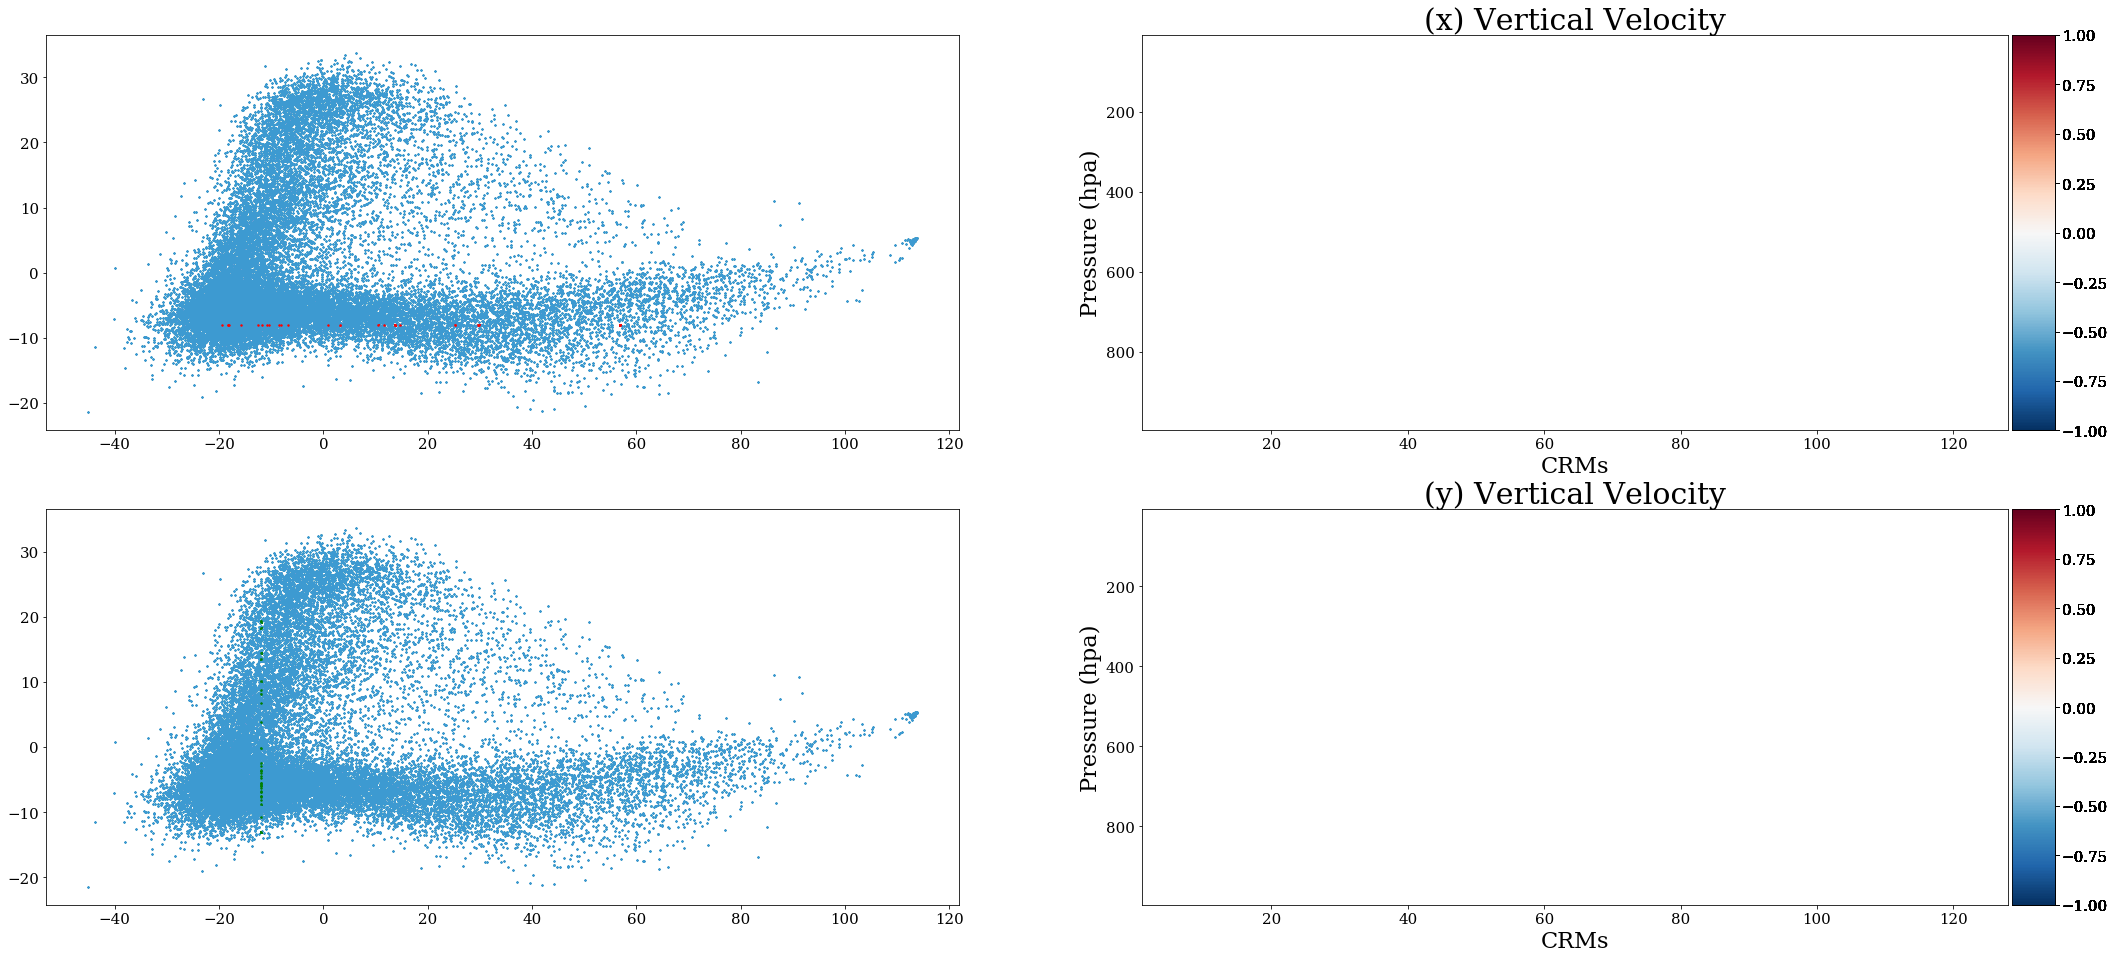

In [64]:
# change vx/vy to location on sorted images
def mikes_latent_animation(h_coords, v_coords, h_const, v_const, latent_space, xdist, ydist, X, Z, hline, vline, h_images, v_images):
    fig, ax = plt.subplots(2,2, figsize=(36,16))
    feat_list = []
    #the real total you need
    num_steps = len(h_coords)
    #num_steps = 20
    cmap= "RdBu_r"
    
    dummy_horz = np.zeros(shape=(30,128))
    dummy_horz[:,:] = np.nan
    dummy_vert = np.zeros(shape=(30,128))
    dummy_vert[:,:] = np.nan
    count = 29
    for i in range(num_steps):
        
        for j in range(len(dummy_horz)):
            dummy_horz[count,:] = h_images[i,j,:]
            if i <= len(v_coords) -1:
                dummy_vert[count,:] = v_images[i,j,:]
            else:
                dummy_vert[count,:] = v_images[-1,j,:]
            count = count-1
        
        h_rect = patches.Rectangle((h_coords[i],h_const),xdist,ydist,linewidth=4,edgecolor='black',facecolor='none')
        if i <= len(v_coords) -1:
            v_rect = patches.Rectangle((v_const,v_coords[i]),xdist,ydist,linewidth=4,edgecolor='black',facecolor='none')
        else:
            v_rect = patches.Rectangle((v_const,v_coords[-1]),xdist,ydist,linewidth=4,edgecolor='black',facecolor='none')
        
        
        
        ax[0,0].scatter(latent_space[:, 0], latent_space[:, 1], c="#3D9AD1", s=0.4,  animated=True)
        ax[0,0].scatter(x=hline[:, 0], y=hline[:, 1], c="Red", s=2.0,  animated=True)
        cs0 = ax[0,0].add_patch(h_rect)
        
        cs2 = ax[1,0].scatter(latent_space[:, 0], latent_space[:, 1], c="#3D9AD1", s=0.4,  animated=True)
        ax[1,0].scatter(x=vline[:, 0], y=vline[:, 1], c="Green", s=2.0, animated=True)
        cs2 = ax[1,0].add_patch(v_rect)
        
        
        cs3 = ax[1,1].pcolor(X, Z, dummy_vert, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        ax[1,1].set_title("(y) Vertical Velocity", fontsize=fz*2.0)
        cs1  = ax[0,1].pcolor(X, Z, dummy_horz, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        ax[0,1].set_title("(x) Vertical Velocity", fontsize=fz*2.0)
        
        ax[0,1].set_xlabel("CRMs", fontsize=fz*1.5)
        ax[1,1].set_xlabel("CRMs", fontsize=fz*1.5)
        ax[0,1].set_ylabel("Pressure (hpa)", fontsize=fz*1.5)
        ax[1,1].set_ylabel("Pressure (hpa)", fontsize=fz*1.5)
        
        y_ticks = np.array([1000, 800, 600, 400, 200])
        ax[1,1].set_yticklabels(y_ticks)
        ax[0,1].set_yticklabels(y_ticks)
        
        divider = make_axes_locatable(ax[1,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs1, cax=cax)
        divider = make_axes_locatable(ax[0,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs1, cax=cax)
        
        feat_list.append([cs2, cs3, cs1, cs0])
        

        count = 29 
        
    ani = animation.ArtistAnimation(fig, feat_list, interval = 125, blit = False, repeat = True)
    ani.save('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Animations/Figures/31_PCA_Horz_Vert.mp4')
    plt.show()
        
    
mikes_latent_animation(horz_line_latent_sorted[:,0], vert_line_latent_sorted[:,1], -8.0, -12.0, z_test_tsne, 0.2, 1, Xs, Zs, horz_line_latent_sorted, vert_line_latent_sorted, horz_line_images_sorted, vert_line_images_sorted)